In [ ]:
!pip install torch torchvision
!pip install cython
!pip install pycocotools


  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (99 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21

In [ ]:
import os
from google.colab import drive
drive.mount("/content/drive")
path="/content/drive/MyDrive/Colab Notebooks/frcnn" # Please enter the directory for your repective files
os.chdir(path)
os.listdir(path)

Mounted at /content/drive


['test_images',
 'train_images',
 'xml',
 '.ipynb_checkpoints',
 'annotations.csv',
 'images',
 'annotate.txt']

In [ ]:
# Read and display the contents of the annotate.txt file
with open('/content/drive/MyDrive/Colab Notebooks/frcnn/annotate.txt', 'r') as file:
    content = file.read()

print(content)


test_images/4.jpg,121,36,179,73,ChickenCrown
test_images/4.jpg,112,59,135,78,ChickenEye
test_images/4.jpg,152,82,214,156,ChickenTail
test_images/4.jpg,108,160,166,185,ChickenFeet
test_images/4.jpg,124,289,157,311,ChickenCrown
test_images/4.jpg,148,304,163,315,ChickenEye
test_images/4.jpg,104,316,141,358,ChickenTail
test_images/4.jpg,130,362,164,377,ChickenFeet
test_images/2.jpg,124,182,181,214,ChickenCrown
test_images/2.jpg,169,203,190,221,ChickenEye
test_images/2.jpg,87,227,150,299,ChickenTail
test_images/2.jpg,139,299,196,330,ChickenFeet
test_images/2.jpg,420,221,476,255,ChickenCrown
test_images/2.jpg,408,244,430,262,ChickenEye
test_images/2.jpg,448,268,512,338,ChickenTail
test_images/2.jpg,406,345,461,372,ChickenFeet
test_images/3.jpg,376,94,434,131,ChickenCrown
test_images/3.jpg,420,120,441,139,ChickenEye
test_images/3.jpg,339,142,400,217,ChickenTail
test_images/3.jpg,392,219,448,247,ChickenFeet
test_images/3.jpg,53,228,83,249,ChickenCrown
test_images/3.jpg,77,242,87,251,ChickenEye

In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import os

# Define the class to index mapping
class_to_idx = {
    "ChickenCrown": 1,
    "ChickenEye": 2,
    "ChickenTail": 3,
    "ChickenFeet": 4
}

# Define the reverse mapping from index to class
idx_to_class = {v: k for k, v in class_to_idx.items()}

class CustomDataset(Dataset):
    def __init__(self, root, annotations, transform=None):
        self.root = root
        self.transform = transform
        with open(annotations) as f:
            self.data = [line.strip().split(',') for line in f.readlines()]

    def __getitem__(self, idx):
        img_path, xmin, ymin, xmax, ymax, label = self.data[idx]
        img_path = os.path.join(self.root, os.path.basename(img_path))  # Correctly join the path
        img = Image.open(img_path).convert("RGB")
        if self.transform:
            img = self.transform(img)

        boxes = torch.tensor([[int(xmin), int(ymin), int(xmax), int(ymax)]], dtype=torch.float32)
        labels = torch.tensor([class_to_idx[label]], dtype=torch.int64)

        target = {
            'boxes': boxes,
            'labels': labels
        }

        return img, target

    def __len__(self):
        return len(self.data)

class CustomTestDataset(Dataset):
    def __init__(self, root, transform=None):
        self.root = root
        self.transform = transform
        self.images = [os.path.join(root, img) for img in os.listdir(root) if img.endswith('.jpg')]

    def __getitem__(self, idx):
        img_path = self.images[idx]
        img = Image.open(img_path).convert("RGB")
        if self.transform:
            img = self.transform(img)
        return img, img_path

    def __len__(self):
        return len(self.images)

# Define the data transforms
transform = transforms.Compose([
    transforms.ToTensor()
])



# Create the datasets
train_dataset = CustomDataset(root='/content/drive/MyDrive/Colab Notebooks/frcnn/train_images', annotations='/content/drive/MyDrive/Colab Notebooks/frcnn/annotate.txt', transform=transform) # please set to correct directory
test_dataset = CustomTestDataset(root='/content/drive/MyDrive/Colab Notebooks/frcnn/test_images', transform=transform)



# Create the data loaders
train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True, collate_fn=lambda x: tuple(zip(*x)))
test_loader = DataLoader(test_dataset, batch_size=2, shuffle=False)


In [ ]:
import torchvision
from torchvision.models.detection import fasterrcnn_resnet50_fpn

def get_model(num_classes):
    # Load a model pre-trained on COCO and then fine-tune it
    model = fasterrcnn_resnet50_fpn(pretrained=True)
    # Get the number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # Replace the pre-trained head with a new one
    model.roi_heads.box_predictor = torchvision.models.detection.faster_rcnn.FastRCNNPredictor(in_features, num_classes)
    return model

# 4 classes + background
model = get_model(num_classes=5)


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth
100%|██████████| 160M/160M [00:02<00:00, 76.4MB/s]


In [ ]:
import os

# List files in train_images directory
train_images_dir = '/content/drive/MyDrive/Colab Notebooks/frcnn/train_images'
print("Training Images:")
for filename in os.listdir(train_images_dir):
    if filename.endswith(".jpg"):
        print(os.path.join(train_images_dir, filename))

# List files in test_images directory
test_images_dir = '/content/drive/MyDrive/Colab Notebooks/frcnn/test_images'
print("\nTesting Images:")
for filename in os.listdir(test_images_dir):
    if filename.endswith(".jpg"):
        print(os.path.join(test_images_dir, filename))


Training Images:
/content/drive/MyDrive/Colab Notebooks/frcnn/train_images/11.jpg
/content/drive/MyDrive/Colab Notebooks/frcnn/train_images/14.jpg
/content/drive/MyDrive/Colab Notebooks/frcnn/train_images/13.jpg
/content/drive/MyDrive/Colab Notebooks/frcnn/train_images/1.jpg
/content/drive/MyDrive/Colab Notebooks/frcnn/train_images/5.jpg
/content/drive/MyDrive/Colab Notebooks/frcnn/train_images/10.jpg
/content/drive/MyDrive/Colab Notebooks/frcnn/train_images/18.jpg
/content/drive/MyDrive/Colab Notebooks/frcnn/train_images/0.jpg
/content/drive/MyDrive/Colab Notebooks/frcnn/train_images/4.jpg
/content/drive/MyDrive/Colab Notebooks/frcnn/train_images/6.jpg
/content/drive/MyDrive/Colab Notebooks/frcnn/train_images/16.jpg
/content/drive/MyDrive/Colab Notebooks/frcnn/train_images/7.jpg
/content/drive/MyDrive/Colab Notebooks/frcnn/train_images/9.jpg
/content/drive/MyDrive/Colab Notebooks/frcnn/train_images/17.jpg
/content/drive/MyDrive/Colab Notebooks/frcnn/train_images/2.jpg
/content/drive/M

In [ ]:
import torch.optim as optim
from torch.utils.data import DataLoader

# Create the data loaders
train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True, collate_fn=lambda x: tuple(zip(*x)))
test_loader = DataLoader(test_dataset, batch_size=2, shuffle=False, collate_fn=lambda x: tuple(zip(*x)))

# Training parameters
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)
params = [p for p in model.parameters() if p.requires_grad]
optimizer = optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)
num_epochs = 1 # Change the number of epochs trained in each run, larger models are usually set to 100, but it's set to 1 for now to save time.

for epoch in range(num_epochs):
    model.train()
    i = 0
    for images, targets in train_loader:
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

        if i % 10 == 0:
            print(f"Epoch {epoch}, Iteration {i}, Loss: {losses.item()}")
        i += 1
    print(f"Epoch {epoch} finished.")

print("Training complete.")


/usr/local/lib/python3.10/dist-packages/torch/autograd/graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Epoch 0, Iteration 0, Loss: 2.205990791320801
Epoch 0, Iteration 10, Loss: 0.5627371072769165
Epoch 0, Iteration 20, Loss: 0.2837851941585541
Epoch 0, Iteration 30, Loss: 0.19005343317985535
Epoch 0, Iteration 40, Loss: 0.3441409766674042
Epoch 0, Iteration 50, Loss: 0.2726346254348755
Epoch 0, Iteration 60, Loss: 0.26598748564720154
Epoch 0, Iteration 70, Loss: 0.20821517705917358
Epoch 0, Iteration 80, Loss: 0.21703678369522095
Epoch 0, Iteration 90, Loss: 0.17006690800189972
Epoch 0, Iteration 100, Loss: 0.16818377375602722
Epoch 0, Iteration 110, Loss: 0.19676123559474945
Epoch 0, Iteration 120, Loss: 0.20425693690776825
Epoch 0, Iteration 130, Loss: 0.18711745738983154
Epoch 0, Iteration 140, Loss: 0.167696014046669
Epoch 0, Iteration 150, Loss: 0.14969630539417267
Epoch 0, Iteration 160, Loss: 0.1627531796693802
Epoch 0, Iteration 170, Loss: 0.2212628573179245
Epoch 0, Iteration 180, Loss: 0.14966638386249542
Epoch 0, Iteration 190, Loss: 0.13574360311031342
Epoch 0, Iteration 20

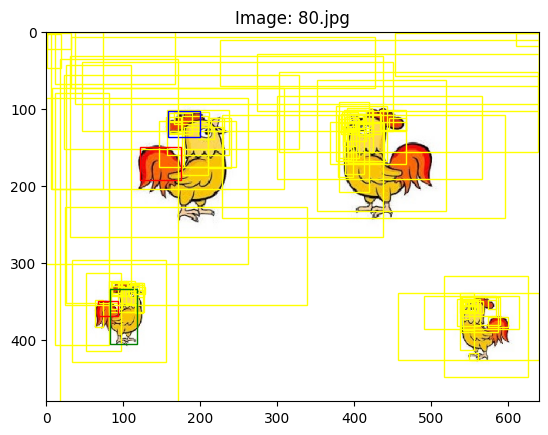

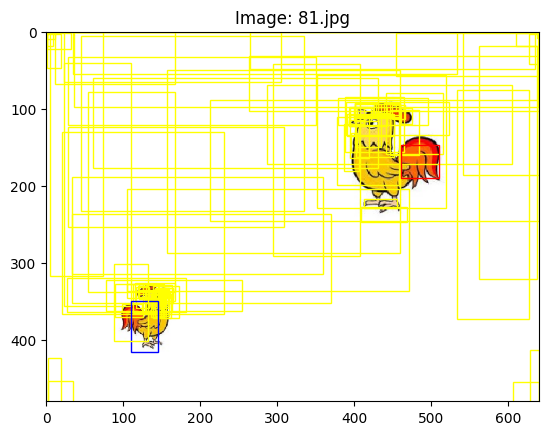

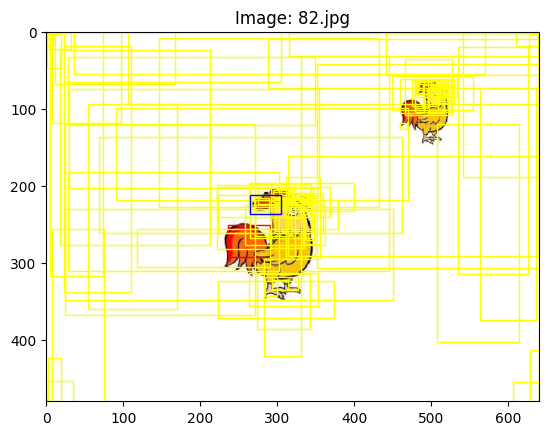

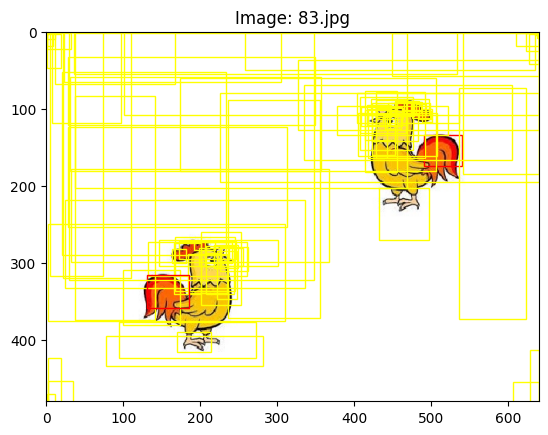

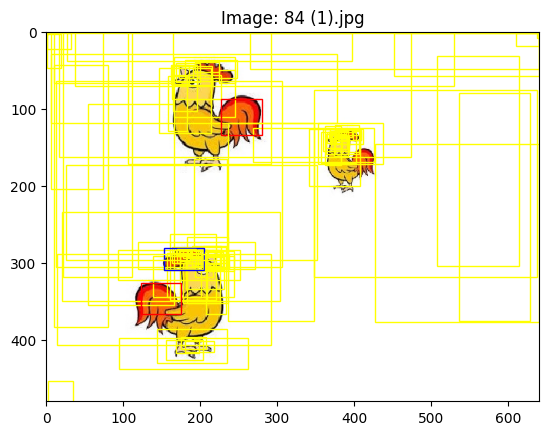

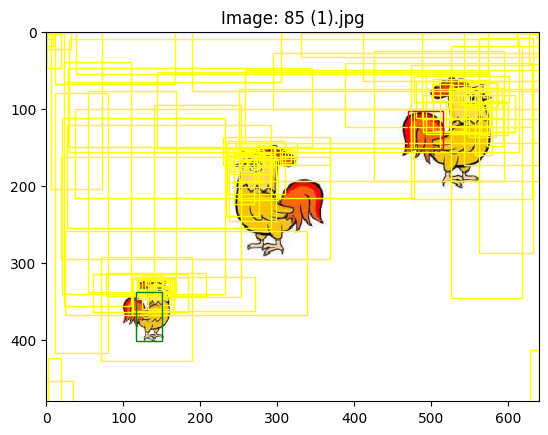

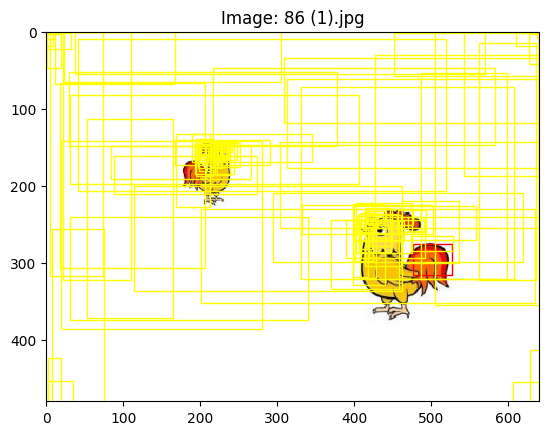

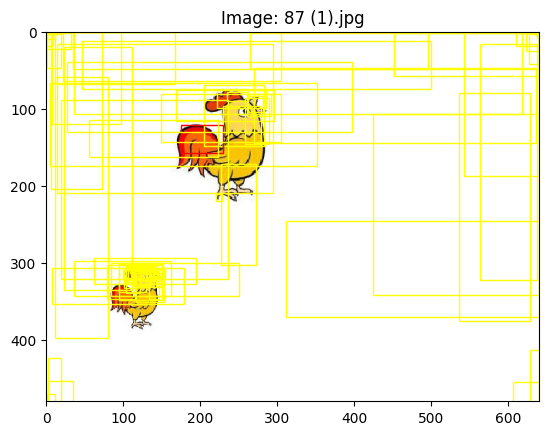

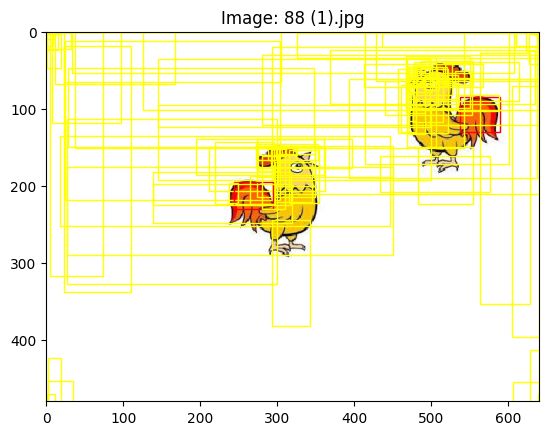

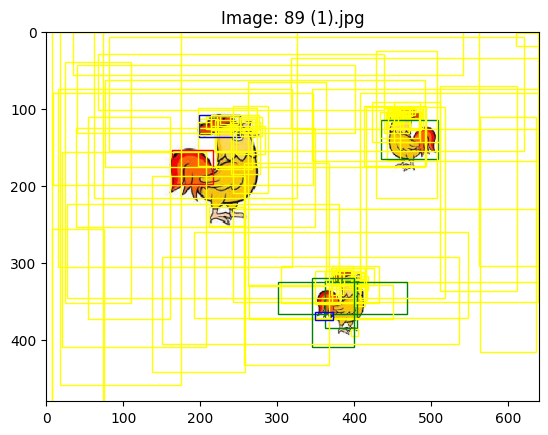

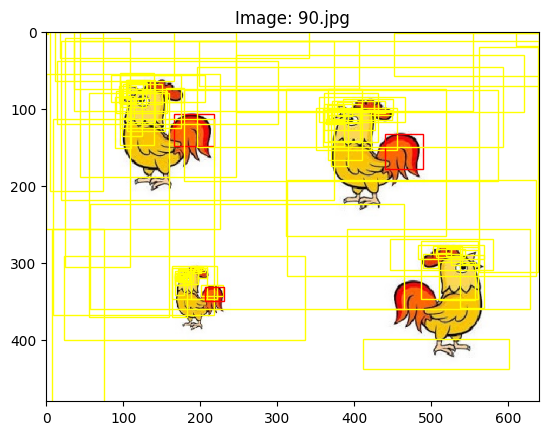

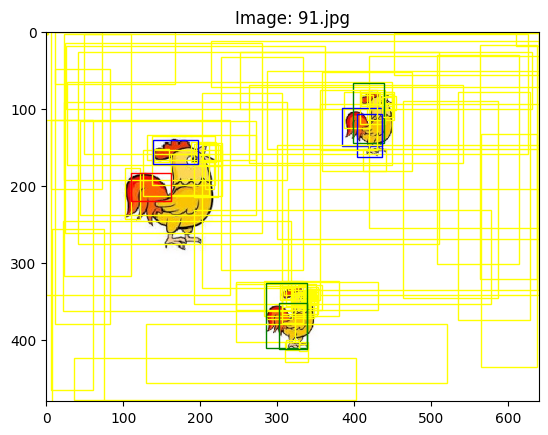

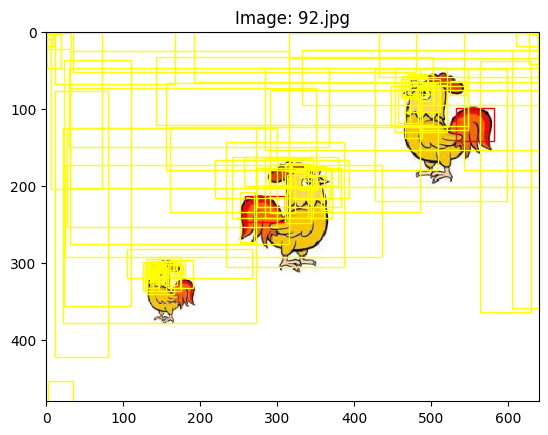

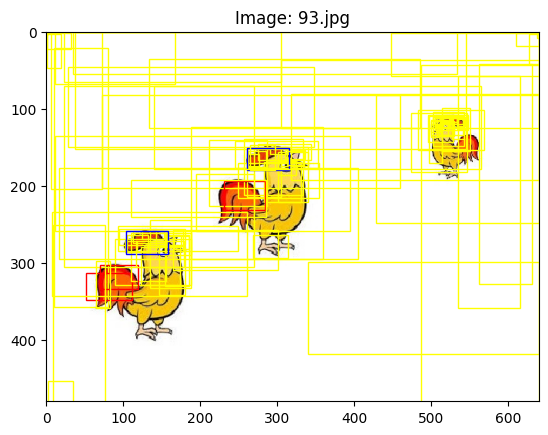

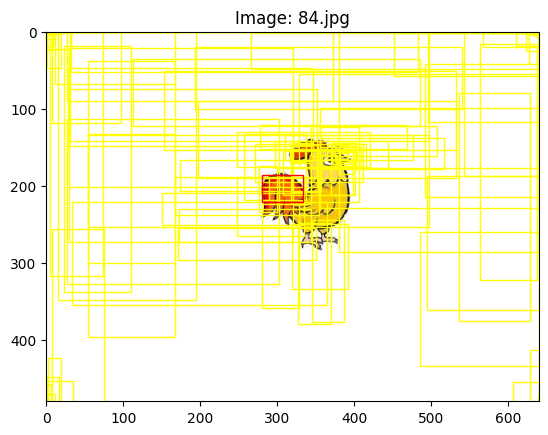

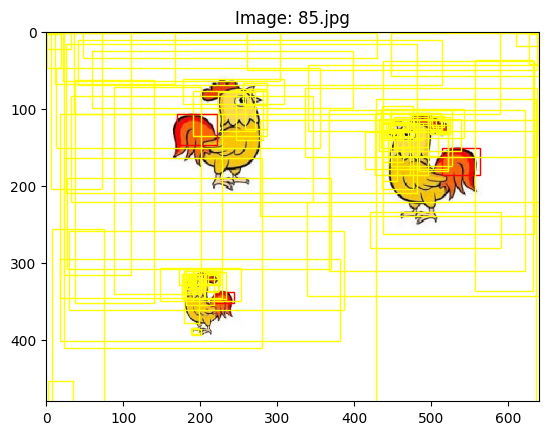

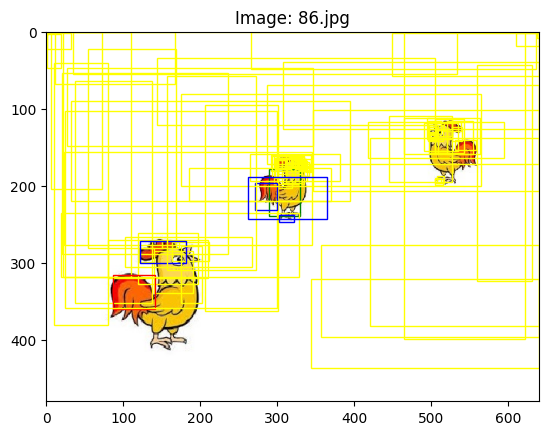

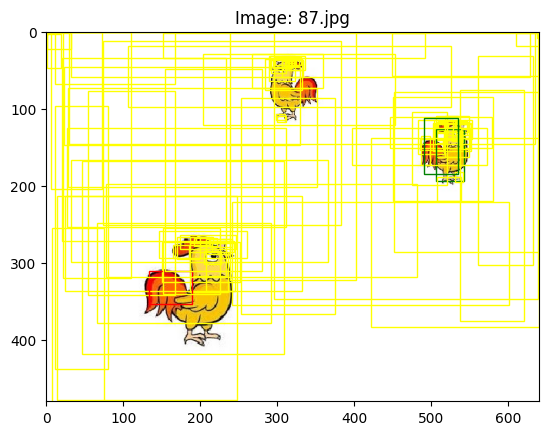

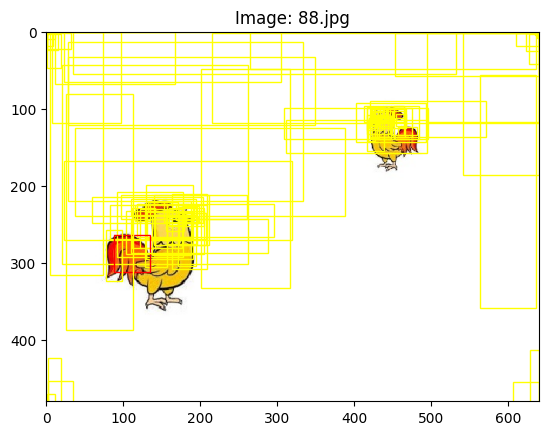

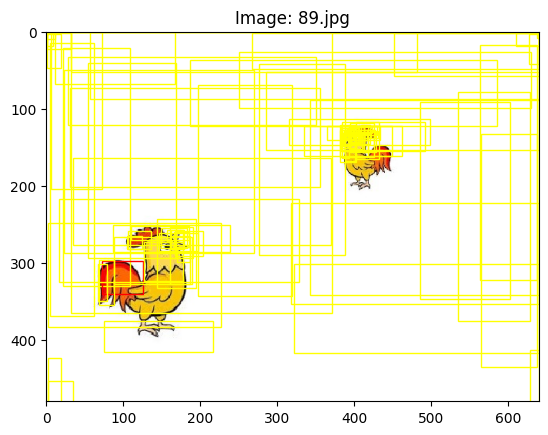

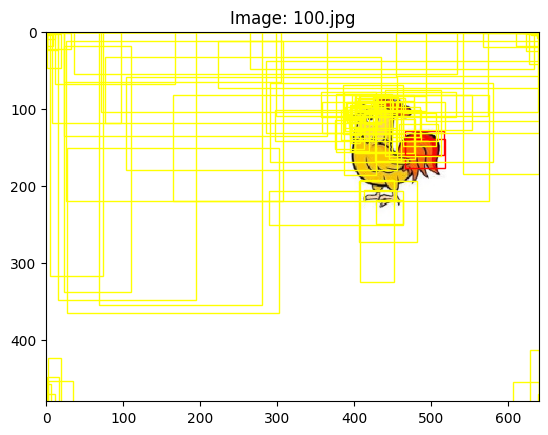

In [ ]:
import matplotlib.pyplot as plt

model.eval()
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)

for images, img_paths in test_loader:
    images = list(image.to(device) for image in images)
    with torch.no_grad():
        outputs = model(images)

    for i, image in enumerate(images):
        img = image.permute(1, 2, 0).cpu().numpy()
        plt.imshow(img)
        for box, label in zip(outputs[i]['boxes'].cpu().numpy(), outputs[i]['labels'].cpu().numpy()):
            if (label==1):
              plt.gca().add_patch(plt.Rectangle((box[0], box[1]), box[2] - box[0], box[3] - box[1], linewidth=1, edgecolor='g', facecolor='none'))
            if (label==2):
              plt.gca().add_patch(plt.Rectangle((box[0], box[1]), box[2] - box[0], box[3] - box[1], linewidth=1, edgecolor='r', facecolor='none'))
            if (label==3):
              plt.gca().add_patch(plt.Rectangle((box[0], box[1]), box[2] - box[0], box[3] - box[1], linewidth=1, edgecolor='b', facecolor='none'))
            if (label==4):
              plt.gca().add_patch(plt.Rectangle((box[0], box[1]), box[2] - box[0], box[3] - box[1], linewidth=1, edgecolor='yellow', facecolor='none'))
            # if (label==0):
            #   plt.text(box[0], box[1] - 10, idx_to_class[label], color='b', fontsize=12, weight='bold')
            # plt.text(box[0], box[1] - 10, label, color='r', fontsize=12, weight='bold')
        plt.title(f'Image: {os.path.basename(img_paths[i])}')
        plt.show()